# Extracting MeOAc Data

In Yates & McClellane, 1967 there are reported values for rate vs [H2SO4] in extreme acid mixtures for hydrolysis of esters. The MeOAc data set is incomplete. The highest acidity results are not reported in the table biut are shown on the plot (Fig 1 and 3 in the paper). To be able to reproduce the plot of Figure 1, I need to get that data.

"Mechanisms of ester hydrolysis in aqueous sulfuric acids." Keith Yates and Robert A. McClelland, *J. Am. Chem. Soc.*, **1967**, *89*, 2686-2692. https://doi.org/10.1021/ja00987a033

## Step 1: Digitize Plot. 

I used WebPlotDigitizer to extract the data. Figure 3 had the best resolution and separation of data points for MeOAc but required conversion of the results. 

First we will digitize the results from Fig 1.

<img src="data/Yates-McClelland-1967-F1.png" style="width:400px">

## Setup

the code below will setup libraries and variables

In [ ]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_styles = "./styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000


## Comparing Data

Below we will plot the data for rate vs %H2SO4 for the data from table 1 of the paper



,%H2SO4,10^2kobs
0,14.48,1.52
1,20.98,2.65
2,28.49,4.23
3,35.01,6.40
4,40.91,8.15
5,45.82,10.37
6,55.79,13.30
7,60.65,13.81
8,65.45,11.92
9,70.99,7.25


,Ester,%H2SO4,kobs
0,MeOAc,14.1,1.500
1,MeOAc,20.7,2.610
2,MeOAc,28.3,4.220
3,MeOAc,34.8,6.410
4,MeOAc,40.4,8.140
5,MeOAc,45.4,10.400
6,MeOAc,50.2,11.400
7,MeOAc,55.2,13.300
8,MeOAc,60.4,13.800
9,MeOAc,65.2,11.900


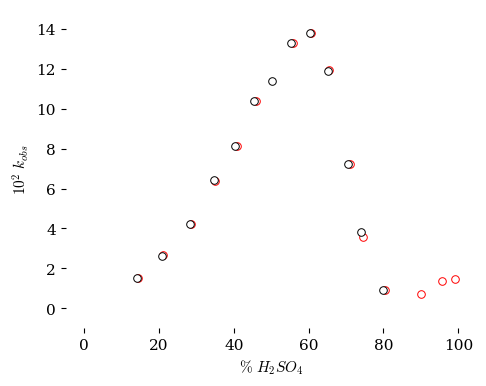

In [ ]:
###################################################
### Import the data and perform calculations
###################################################

Data_File_Name = "Yates_Figure1_Digitized.csv"
#Data_File_Name = "Yates_Figure1_Digitized2.csv"
Filename = github_location + Data_File_Name

df_digitized = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 

#print("Data from digitized Figure 1\n")
display(df_digitized)

###################################################

Data_File_Name = "Yates_Table1.csv"
Filename = github_location + Data_File_Name

df_table1 = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
df_table1 = (df_table1.loc[df_table1['Ester'] == 'MeOAc'])   ### Select only the MeOAc data
df_table1 = df_table1.iloc[:-3]               ### Remove last three rows which are digitized data from figure 3
df_table1 = df_table1.reset_index(drop=True)  ### Reset the index so its sequential after removing rows

#print("Data from Table 1")
display(df_table1)

###################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

y_label = r"$10^2\ k_{obs}$"
x_label = r"$\%\ H_2SO_4$"


###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set(ylabel=y_label, xlabel=x_label,
           xlim=[-5,105],
           ylim=[-1,15]
           )
# Data points for kobs vs Acidity
x = df_digitized["%H2SO4"]
y = df_digitized["10^2kobs"]#/(10**2)

ax.scatter(x, y, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "red", linewidths=0.7, 
          zorder = 2)
ax.scatter(x, y,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)

# Data points for kobs vs Acidity
x1 = df_table1["%H2SO4"]
y1 = df_table1["kobs"]#/(10**2)

ax.scatter(x1, y1, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(x1, y1,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)
if False:                       # Data points for kobs vs Acidity
    a = linregress(x,y)
    print(a)
    y_line = a.slope * x + a.intercept

    ax.plot(x, y_line,    # Plot line fit
            "-", color = "black", linewidth=0.7, 
            zorder = 0)

plt.savefig("plots/03_F02_plot1.pdf")
plt.show()


Mean x deviation is 0.369 +/- 0.135
Mean y deviation is 0.004 +/i 0.019


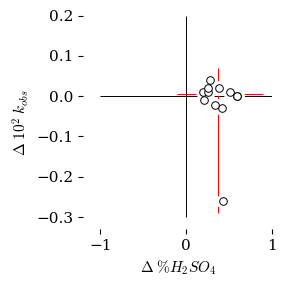

0     0.020
1     0.040
2     0.010
3    -0.010
4     0.010
5    -0.030
6     0.000
7     0.010
8     0.020
9     0.000
10   -0.260
11   -0.021
dtype: float64


In [ ]:
# Delta Plot
#x1d = x1
#y1d = y1
x1d = x1.drop(6).reset_index(drop=True) # Drop a point that is not included in both sets of data
y1d = y1.drop(6).reset_index(drop=True)
xd = x.iloc[:-3].reset_index(drop=True) # drop the last three points that are not included in both sets of data
yd = y.iloc[:-3].reset_index(drop=True)

dX = xd-x1d
dY = yd-y1d  

ave_dX = np.mean(dX)
ave_dY = np.mean(dY)

###################################################
### MAKE PLOT
###################################################

###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

y_label = r"$\Delta\; 10^2\;k_{obs}$"
x_label = r"$\Delta\; \%H_2SO_4$"


###################################################
### RATE vs ACIDITY Plot
###################################################

# Set up axes for main plot
ax.set(ylabel=y_label, xlabel=x_label,
        xlim=[-1.2,1],
        ylim=[-0.33 ,0.2]
        )
# Data points for kobs vs Acidity

ax.scatter(dX, dY, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)
ax.scatter(dX, dY,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 1)
ax.hlines(0,-1,1, colors='black', zorder=0, linewidth=0.7)
ax.vlines(0,-.3,.2, colors='black', zorder=0, linewidth=0.7)
ax.vlines(np.mean(dX),np.min(dY)-0.03,np.max(dY)+0.03, colors='red', zorder=0, linewidth=0.7)

dY_no_min = dY[dY != dY.min()].reset_index(drop=True) # remove outlier from y values
ax.hlines(np.mean(dY_no_min),np.min(dX)-0.3,np.max(dX)+0.3, colors='red', zorder=0, linewidth=0.7)
print(f"Mean x deviation is {np.mean(dX):0.3f} +/- {np.std(dX):0.3f}")
print(f"Mean y deviation is {np.mean(dY_no_min):0.3f} +/i {np.std(dY_no_min):0.3f}")

np.std(dX)
plt.savefig("plots/03_F03_plot2.pdf")
plt.show()

print(dY)

In [ ]:
dY_no_min = dY[dY != dY.min()].reset_index(drop=True)
print(dY_no_min)

In [ ]:
df_table1a = df_table1.iloc[:-3]
display(df_table1a)

,Ester,%H2SO4,10^2kobs
0,MeOAc,14.1,1.50
1,MeOAc,20.7,2.61
2,MeOAc,28.3,4.22
3,MeOAc,34.8,6.41
4,MeOAc,40.4,8.14
5,MeOAc,45.4,10.40
6,MeOAc,50.2,11.40
7,MeOAc,55.2,13.30
8,MeOAc,60.4,13.80
9,MeOAc,65.2,11.90


## Bibliography

"Mechanisms of ester hydrolysis in aqueous sulfuric acids." Keith Yates and Robert A. McClelland, *J. Am. Chem. Soc.*, **1967**, *89*, 2686-2692. https://doi.org/10.1021/ja00987a033

In [12]:
##############################################################
### DATAFRAME for ESTER HYDROLYSIS KINETIC DATA
##############################################################

##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "Yates_Table1.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
#display(df)

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data
#df1 = (df1.loc[0:11])   ### Select only the given lines

##############################################################
### Perform calculations
##############################################################

df1["kobs"] = df1["kobs"] * 1E-2 * 60    # convert from 10^-2 min^-1 to s^-1
#df1["kobs"] = df1["kobs"]

PercentH2SO4 = df1["%H2SO4"]
molesH2SO4 = PercentH2SO4 / molwtH2SO4
PercentH2O = 100 - PercentH2SO4
molesH2O = PercentH2O / molwtH2O
total_moles = molesH2SO4 + molesH2O
mole_fraction_H2SO4 = molesH2SO4 / total_moles

df1["X_H2SO4"] = mole_fraction_H2SO4

interpolatorH0 = interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolatorH0(PercentH2SO4)

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"])

interpolator_aH2O = interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
df1["aH2O"] = interpolator_aH2O(PercentH2SO4)

interpolator_density = interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()
density = interpolator_density(PercentH2SO4)

volume = 1000
gramsH2O = volume * density * PercentH2O/100
molesH2O = gramsH2O / molwtH2O    # per liter

df1["Molar_H2O"] = molesH2O
X_H2O = 1-df1["X_H2SO4"]          # mole fraction H2O in H2SO4
gamma_H2O = df1["aH2O"]/(X_H2O)   # activity coefficient for H2O in H2SO4
df1["Molar_aH2O"] = gamma_H2O * df1["Molar_H2O"]

display(df1)

,Ester,%H2SO4,kobs,X_H2SO4,H0,HS,log_k_obs,aH2O,Molar_H2O,Molar_aH2O
0,MeOAc,14.1,0.9000,0.029243,-0.602729,-0.373692,-0.045757,0.929672,52.274995,50.062576
1,MeOAc,20.7,1.5660,0.045716,-1.037527,-0.643266,0.194792,0.873362,50.455747,46.177140
2,MeOAc,28.3,2.5320,0.067544,-1.511469,-0.937111,0.403464,0.778090,48.018423,40.069105
3,MeOAc,34.8,3.8460,0.089215,-1.999334,-1.239587,0.585009,0.668753,45.583388,33.470084
4,MeOAc,40.4,4.8840,0.110638,-2.418862,-1.499694,0.688776,0.556825,43.253973,27.081094
5,MeOAc,45.4,6.2400,0.132397,-2.793058,-1.731696,0.795185,0.449579,40.993888,21.242417
6,MeOAc,50.2,6.8400,0.156117,-3.233884,-2.005008,0.835056,0.346582,38.654075,15.875174
7,MeOAc,55.2,7.9800,0.184424,-3.781791,-2.344711,0.902003,0.246168,36.027011,10.874154
8,MeOAc,60.4,8.2800,0.218701,-4.396537,-2.725853,0.918030,0.156455,33.060974,6.620468
9,MeOAc,65.2,7.1400,0.255866,-5.004720,-3.102926,0.853698,0.091126,30.074416,3.682898


In [13]:
Data_File_Name = "02_H0_H2SO4_Tickle_1970.csv"
Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 comment = "#") 
df_sorted = df.sort_values(by="H0", ascending=True). # interpolator required x-axis to be accending in order to work
y = df["%H2SO4"]
x = df["H0"]

interpolation = make_smoothing_spline(x, y,      ### The x and y data
                                      w=None,    ### A list of weights for each point (default = None)
                                      lam=5)   ### A factor for the degree of smoothing. Change this to change the smoothness.


SyntaxError: invalid syntax (1775470303.py, line 8)